The second edition of *Think DSP* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

(chapter-filtering-and-convolution)=
# Filtering and Convolution

In this chapter I present one of the most important and useful ideas related to signal processing: the Convolution Theorem.
But before we can understand the Convolution Theorem, we have to understand convolution.
I'll start with a simple example, smoothing, and we'll go from there.

The code for this chapter is in `chap08.ipynb`, which is in the repository for this book (see Section [\[code\]](#code){reference-type="ref" reference="code"}).
You can also view it at <http://tinyurl.com/thinkdsp08>.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkDSP2/blob/main/soln/chap08.ipynb).

In [1]:
import importlib, sys
sys.modules["imp"] = importlib

%load_ext autoreload
%autoreload 2

In [2]:
# download thinkdsp.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download("https://github.com/AllenDowney/ThinkDSP2/raw/main/soln/thinkdsp.py")

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import thinkdsp
from thinkdsp import decorate, decorate_time, decorate_freq, decorate_corr

(section-smoothing)=
## Smoothing

Smoothing is an operation that tries to remove short-term variations from a signal in order to reveal long-term trends.
For example, if you plot daily changes in the price of a stock, it would look noisy; a smoothing operator might make it easier to see whether the price was generally going up or down over time.

A common smoothing algorithm is a moving average, which computes the mean of the previous $n$ values, for some value of $n$.

For example, the following figure shows the daily closing price of Facebook from May 17, 2012 to December 8, 2015.
The gray line is the raw data, the darker line shows the 30-day moving average.
Smoothing removes the most extreme changes and makes it easier to see long-term trends.

In [4]:
import pandas as pd

download('https://github.com/AllenDowney/ThinkDSP/raw/master/code/FB_2.csv')

df = pd.read_csv('FB_2.csv', header=0, parse_dates=[0])

In [5]:
close = df['Close']
dates = df['Date']
days = (dates - dates[0]) / np.timedelta64(1,'D')

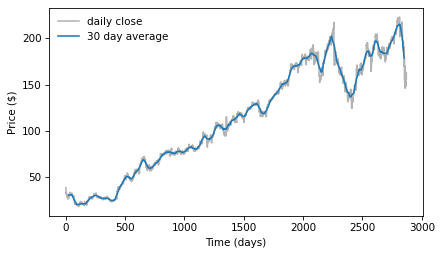

In [6]:
M = 30
window = np.ones(M)
window /= sum(window)
smoothed = np.convolve(close, window, mode='valid')
smoothed_days = days[M//2: len(smoothed) + M//2]

plt.plot(days, close, color='0.7', label='daily close')
plt.plot(smoothed_days, smoothed, label='30 day average')

decorate(xlabel='Time (days)', ylabel='Price ($)')

Smoothing operations also apply to sound signals.
As an example, I'll start with a square wave at 440 Hz. As we saw in Section [\[square\]](#square){reference-type="ref" reference="square"}, the harmonics of a square wave drop off slowly, so it contains many high-frequency components.

In [7]:
from thinkdsp import SquareSignal

signal = SquareSignal(freq=440)
wave = signal.make_wave(duration=1, framerate=44100)
segment = wave.segment(duration=0.01)

`wave` is a 1-second segment of the signal; `segment` is a shorter segment I'll use for plotting.

To compute the moving average of this signal, I'll create a window with 11 elements and normalize it so the elements add up to 1.

In [8]:
window = np.ones(11)
window /= sum(window)

Now I can compute the average of the first 11 elements by multiplying the window by the wave array:

In [9]:
ys = segment.ys
N = len(ys)
padded = thinkdsp.zero_pad(window, N)
prod = padded * ys
sum(prod)

-1.0000000000000002

`padded` is a version of the window with zeros added to the end so it has the same length as `segment.ys`.

`prod` is the product of the window and the wave array.

The sum of the elementwise products is the average of the first 11 elements of the array.
Since these elements are all -1, their average is -1.

To compute the next element of the smoothed signal, we shift the window to the right and compute the average of the next 11 elements of the wave array, starting with the second.

In [10]:
rolled = np.roll(padded, 1)
prod = rolled * ys
sum(prod)

-1.0000000000000002

The result is -1 again.
To compute the moving average, we repeat this process and store the result in an array named `smoothed`:

In [11]:
smoothed = np.zeros(N)
rolled = padded.copy()
for i in range(N):
    smoothed[i] = sum(rolled * ys)
    rolled = np.roll(rolled, 1)

`rolled` is a copy of `padded` that gets shifted to the right by one element each time through the loop.
Inside the loop, we multiply the segment by `rolled` to select 11 elements, and then add them up.

The following figure shows the result.

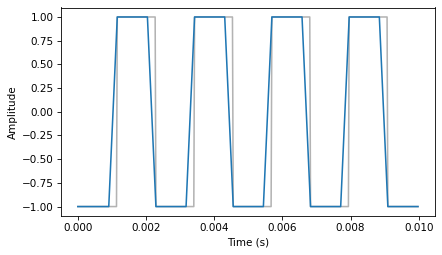

In [12]:
segment.plot(color='0.7')
smooth = thinkdsp.Wave(smoothed, framerate=wave.framerate)
smooth.plot()
decorate_time()

The gray line is the original signal; the darker line is the smoothed signal.
The smoothed signal starts to ramp up when the leading edge of the window reaches the first transition, and levels off when the window crosses the transition.
As a result, the transitions are less abrupt, and the corners less sharp.
If you listen to the smoothed signal, it sounds less buzzy and slightly muffled.

(section-convolution)=
## Convolution

The operation we just computed is called **convolution**, and it is such a common operation that NumPy provides an implementation that is simpler and faster than my version:

In [13]:
convolved = np.convolve(ys, window, mode='valid')
smooth2 = thinkdsp.Wave(convolved, framerate=wave.framerate)

`np.convolve` computes the convolution of the wave array and the window.
The mode flag `valid` indicates that it should only compute values when the window and the wave array overlap completely, so it stops when the right edge of the window reaches the end of the wave array.
Other than that, the result is the same as in the earlier figure.

Actually, there is one other difference.
The loop in the previous section actually computes **cross-correlation**:

$$(f \star g)[n] = \sum_{m=0}^{N-1} f[m] g[n+m]$$

where $f$ is a wave array with length $N$, $g$ is the window, and $\star$ is the symbol for cross-correlation.
To compute the $n$th element of the result, we shift $g$ to the right, which is why the index is $n+m$.

The definition of convolution is slightly different:

$$(f \ast g)[n] = \sum_{m=0}^{N-1} f[m] g[n-m]$$

The symbol $\ast$ represents convolution.
The difference is in the index of $g$: $m$ has been negated, so the summation iterates the elements of $g$ backward (assuming that negative indices wrap around to the end of the array).

Because the window we used in this example is symmetric, cross-correlation and convolution yield the same result.
When we use other windows, we will have to be more careful.

You might wonder why convolution is defined the way it is. There are two reasons:

-   This definition comes up naturally for several applications, especially analysis of signal-processing systems, which is the topic of Chapter [\[systems\]](#systems){reference-type="ref" reference="systems"}.

-   Also, this definition is the basis of the Convolution Theorem, coming up very soon.


(section-the-frequency-domain)=
## The Frequency Domain

Smoothing makes the transitions in a square signal less abrupt, and makes the sound slightly muffled.
Let's see what effect this operation has on the spectrum.
First I'll plot the spectrum of the original wave:

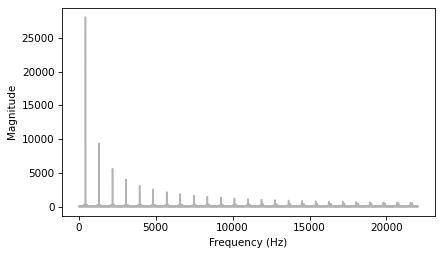

In [14]:
spectrum = wave.make_spectrum()
spectrum.plot(color='0.7')
decorate_freq()

Then the smoothed wave:

In [15]:
convolved = np.convolve(wave.ys, window, mode='same')
smooth = thinkdsp.Wave(convolved, framerate=wave.framerate)

The mode flag `same` indicates that the result should have the same length as the input.
In this example, it will include a few values that "wrap around", but that's ok for now.

The following figure shows the result.

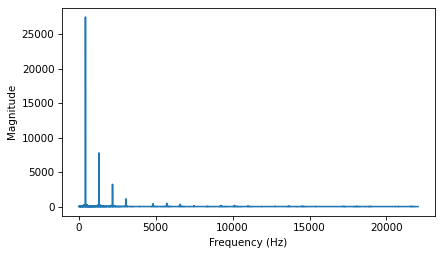

In [16]:
spectrum2 = smooth.make_spectrum()
spectrum2.plot()
decorate_freq()

The fundamental frequency is almost unchanged; the first few harmonics are attenuated, and the higher harmonics are almost eliminated.
So smoothing has the effect of a low-pass filter, which we saw in Section [\[spectrums\]](#spectrums){reference-type="ref" reference="spectrums"} and Section [\[pink\]](#pink){reference-type="ref" reference="pink"}.

To see how much each component has been attenuated, we can compute the ratio of the two spectrums:

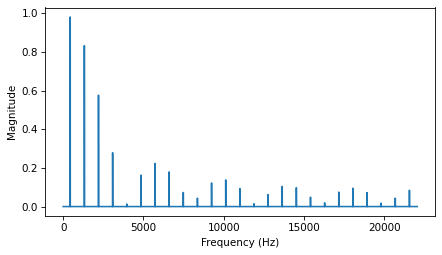

In [17]:
amps = spectrum.amps
amps2 = spectrum2.amps
ratio = amps2 / amps
ratio[amps<560] = 0
plt.plot(ratio)
decorate_freq()

`ratio` is the ratio of the amplitude before and after smoothing.
When `amps` is small, this ratio can be big and noisy, so for simplicity I set the ratio to 0 except where the harmonics are.

The following figure shows the result.
As expected, the ratio is high for low frequencies and drops off at a cutoff frequency near 4000 Hz. But there is another feature we did not expect: above the cutoff, the ratio bounces around between 0 and 0.2. What's up with that?

(section-the-convolution-theorem)=
## The Convolution Theorem

The answer is the convolution theorem.
Stated mathematically:

$$\mathrm{DFT}(f \ast g) = \mathrm{DFT}(f) \cdot \mathrm{DFT}(g)$$

where $f$ is a wave array and $g$ is a window.
In words, the convolution theorem says that if we convolve $f$ and $g$, and then compute the DFT, we get the same answer as computing the DFT of $f$ and $g$, and then multiplying the results element-wise.
More concisely, convolution in the time domain corresponds to multiplication in the frequency domain.

And that explains the earlier figure, because when we convolve a wave and a window, we multiply the spectrum of the wave with the spectrum of the window.
To see how that works, we can compute the DFT of the window:

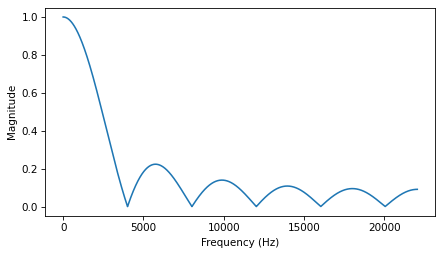

In [18]:
padded = thinkdsp.zero_pad(window, len(wave))
dft_window = np.fft.rfft(padded)
plt.plot(abs(dft_window))
decorate_freq()

`padded` contains the window, padded with zeros to be the same length as `wave`.
`dft_window` contains the DFT of the smoothing window.

The following figure shows the result, along with the ratios we computed in the previous section.
The ratios are exactly the amplitudes in `dft_window`.
Mathematically:

$$\mathrm{abs}(\mathrm{DFT}(f \ast g)) / \mathrm{abs}(\mathrm{DFT}(f)) = \mathrm{abs}(\mathrm{DFT}(g))$$

In this context, the DFT of a window is called a **filter**.
For any convolution window in the time domain, there is a corresponding filter in the frequency domain.
And for any filter that can be expressed by element-wise multiplication in the frequency domain, there is a corresponding window.


(section-gaussian-filter)=
## Gaussian Filter

The moving average window we used in the previous section is a low-pass filter, but it is not a very good one.
The DFT drops off steeply at first, but then it bounces around.
Those bounces are called **sidelobes**, and they are there because the moving average window is like a square wave, so its spectrum contains high-frequency harmonics that drop off proportionally to $1/f$, which is relatively slow.

We can do better with a Gaussian window.
SciPy provides functions that compute many common convolution windows, including ` gaussian`:

In [19]:
import scipy.signal

gaussian = scipy.signal.windows.gaussian(M=11, std=2)
gaussian /= sum(gaussian)

`M` is the number of elements in the window; `std` is the standard deviation of the Gaussian distribution used to compute it. The following figure shows the shape of the window.
It is a discrete approximation of the Gaussian "bell curve".
The figure also shows the moving average window from the previous example, which is sometimes called a **boxcar window** because it looks like a rectangular railway car.

I ran the computations from the previous sections again with this curve, and generated the following figure, which shows the ratio of the spectrums before and after smoothing, along with the DFT of the Gaussian window.

As a low-pass filter, Gaussian smoothing is better than a simple moving average.
After the ratio drops off, it stays low, with almost none of the sidelobes we saw with the boxcar window.
So it does a better job of cutting off the higher frequencies.

The reason it does so well is that the DFT of a Gaussian curve is also a Gaussian curve.
So the ratio drops off in proportion to $\exp(-f^2)$, which is much faster than $1/f$.

(section-efficient-convolution)=
## Efficient Convolution

One of the reasons the FFT is such an important algorithm is that, combined with the Convolution Theorem, it provides an efficient way to compute convolution, cross-correlation, and autocorrelation.

Again, the Convolution Theorem states:

$$\mathrm{DFT}(f \ast g) = \mathrm{DFT}(f) \cdot \mathrm{DFT}(g)$$

So one way to compute a convolution is:

$$f \ast g = \mathrm{IDFT}(\mathrm{DFT}(f) \cdot \mathrm{DFT}(g))$$

where $IDFT$ is the inverse DFT.
A simple implementation of convolution takes time proportional to $N^2$; this algorithm, using FFT, takes time proportional to $N \log N$.

We can confirm that it works by computing the same convolution both ways.
As an example, I'll apply it to the Facebook data shown earlier.

In [20]:
ys = df['Closing Price (USD)'].values if 'Closing Price (USD)' in df.columns else close.values

This example uses Pandas to read the data from the CSV file (included in the repository for this book).
If you are not familiar with Pandas, don't worry: I'm not going to do much with it in this book.
But if you're interested, you can learn more about it in *Think Stats* at <http://thinkstats2.com>.

The result, `df`, is a DataFrame, one of the data structures provided by Pandas.
`ys` is a NumPy array that contains daily closing prices.

Next I'll create a Gaussian window and convolve it with `ys`:

In [21]:
window = scipy.signal.windows.gaussian(M=30, std=6)
window /= window.sum()
smoothed = np.convolve(ys, window, mode='valid')

`fft_convolve` computes the same thing using FFT:

In [22]:
from numpy.fft import fft, ifft

def fft_convolve(signal, window):
    fft_signal = fft(signal)
    fft_window = fft(window)
    return ifft(fft_signal * fft_window)

We can test it by padding the window to the same length as `ys` and then computing the convolution:

In [23]:
N = len(ys)
padded = thinkdsp.zero_pad(window, N)
smoothed2 = fft_convolve(ys, padded)

The result has $M-1$ bogus values at the beginning, where $M$ is the length of the window.
If we slice off the bogus values, the result agrees with `np.convolve` with about 12 digits of precision.

In [24]:
M = len(window)
smoothed2 = smoothed2[M-1:]
max(abs(smoothed - smoothed2.real))

1.9895196601282805e-13

(section-efficient-autocorrelation)=
## Efficient Autocorrelation

In Section [\[convolution\]](#convolution){reference-type="ref" reference="convolution"} I presented definitions of cross-correlation and convolution, and we saw that they are almost the same, except that in convolution the window is reversed.

Now that we have an efficient algorithm for convolution, we can also use it to compute cross-correlations and autocorrelations.
Using the data from the previous section, we can compute the autocorrelation Facebook stock prices:

In [25]:
corrs = np.correlate(close, close, mode='same')

With `mode='same'`, the result has the same length as `close`, corresponding to lags from $-N/2$ to $N/2-1$.
The gray line in the following figure shows the result.
Except at `lag=0`, there are no peaks, so there is no apparent periodic behavior in this signal.
However, the autocorrelation function drops off slowly, suggesting that this signal resembled pink noise, as we saw in Section [\[autopink\]](#autopink){reference-type="ref" reference="autopink"}.

To compute autocorrelation using convolution, we have to zero-pad the signal to double the length.
This trick is necessary because the FFT is based on the assumption that the signal is periodic; that is, that it wraps around from the end to the beginning.
With time-series data like this, that assumption is invalid.
Adding zeros, and then trimming the results, removes the bogus values.

Also, remember that convolution reverse the direction of the window.
In order to cancel that effect, we reverse the direction of the window before calling `fft_convolve`, using `np.flipud`, which flips a NumPy array.
The result is a view of the array, not a copy, so this operation is fast.

In [26]:
def fft_autocorr(signal):
    N = len(signal)
    signal = thinkdsp.zero_pad(signal, 2*N)
    window = np.flipud(signal)

    corrs = fft_convolve(signal, window)
    corrs = np.roll(corrs, N//2+1)[:N]
    return corrs

The result from `fft_convolve` has length $2N$.
Of those, the first and last $N/2$ are valid; the rest are the result of zero-padding.
To select the valid element, we roll the results and select the first $N$, corresponding to lags from $-N/2$ to $N/2-1$.

As shown in the following figure, the results from `fft_autocorr` and `np.correlate` are identical (with about 9 digits of precision).

In [27]:
corrs2 = fft_autocorr(close)
diff = corrs - corrs2
max(abs(diff.real))

2.9802322387695312e-08

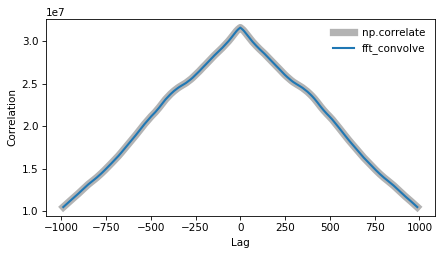

In [28]:
N = len(corrs)
lags = np.arange(N) - N//2
plt.plot(lags, corrs, color='0.7', linewidth=7, label='np.correlate')
plt.plot(lags, corrs2.real, linewidth=2, label='fft_convolve')
decorate_corr()

Notice that the correlations in the earlier figure are large numbers; we could normalize them (between -1 and 1) as shown in Section [\[correlate\]](#correlate){reference-type="ref" reference="correlate"}.

The strategy we used here for auto-correlation also works for cross-correlation.
Again, you have to prepare the signals by flipping one and padding both, and then you have to trim the invalid parts of the result.
This padding and trimming is a nuisance, but that's why libraries like NumPy provide functions to do it for you.

## Exercises

### Exercise 8.1

In this chapter I claimed that the Fourier transform of a Gaussian curve is also a Gaussian curve.
For discrete Fourier transforms, this relationship is approximately true.

Try it out for a few examples.
What happens to the Fourier transform as you vary `std`?


I'll start with a Gaussian similar to the example in the book.

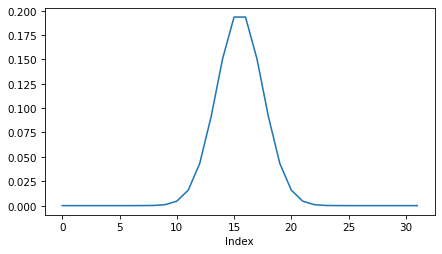

In [29]:
import scipy.signal

gaussian = scipy.signal.windows.gaussian(M=32, std=2)
gaussian /= sum(gaussian)
plt.plot(gaussian)
decorate(xlabel='Index')

Here's what the FFT looks like:

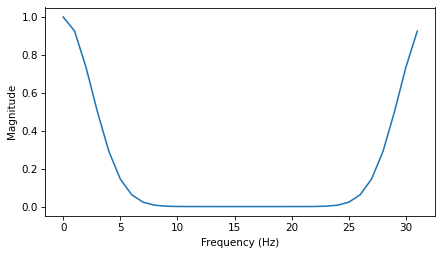

In [30]:
fft_gaussian = np.fft.fft(gaussian)
plt.plot(abs(fft_gaussian))
decorate_freq()

If we roll the negative frequencies around to the left, we can see more clearly that it is Gaussian, at least approximately.

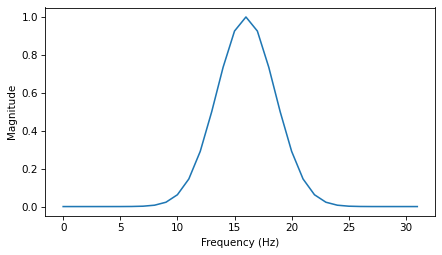

In [31]:
N = len(gaussian)
fft_rolled = np.roll(fft_gaussian, N//2)
plt.plot(abs(fft_rolled))
decorate_freq()

This function plots the Gaussian window and its FFT side-by-side.

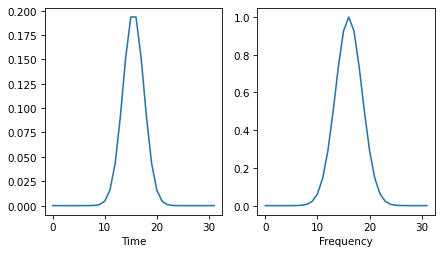

In [32]:
def plot_gaussian(std):
    M = 32
    gaussian = scipy.signal.windows.gaussian(M=M, std=std)
    gaussian /= sum(gaussian)
    
    plt.subplot(1, 2, 1)
    plt.plot(gaussian)
    decorate(xlabel='Time')

    fft_gaussian = np.fft.fft(gaussian)
    fft_rolled = np.roll(fft_gaussian, M//2)
    
    plt.subplot(1, 2, 2)
    plt.plot(np.abs(fft_rolled))
    decorate(xlabel='Frequency')
    plt.show()

plot_gaussian(2)

Now we can make an interaction that shows what happens as `std` varies.

In [33]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

slider = widgets.FloatSlider(min=0.1, max=10, value=2)
interact(plot_gaussian, std=slider);

interactive(children=(FloatSlider(value=2.0, description='std', max=10.0, min=0.1), Output()), _dom_classes=('…

As `std` increases, the Gaussian gets wider and its FFT gets narrower.

In terms of continuous mathematics, if

$f(x) = e^{-a x^2}$

which is a Gaussian with mean 0 and standard deviation $1/a$, its Fourier transform is

$F(k) = \sqrt{\frac{\pi}{a}} e^{-\pi^2 k^2/a}$

which is a Gaussian with standard deviation $a / \pi^2$.
So there is an inverse relationship between the standard deviations of $f$ and $F$.

For the proof, see http://mathworld.wolfram.com/FourierTransformGaussian.html

### Exercise 8.2

If you did the exercises in Chapter 3, you saw the effect of the Hamming window, and some of the other windows provided by NumPy, on spectral leakage.
We can get some insight into the effect of these windows by looking at their DFTs.

In addition to the Gaussian window we used in this window, create a Hamming window with the same size.
Zero pad the windows and plot their DFTs.
Which window acts as a better low-pass filter?  You might find it useful to plot the DFTs on a log-$y$ scale.

Experiment with a few different windows and a few different sizes.


Following the examples from the chapter, I'll create a 1-second wave sampled at 44.1 kHz.

In [34]:
from thinkdsp import SquareSignal

signal = SquareSignal(freq=440)
wave = signal.make_wave(duration=1.0, framerate=44100)

And I'll create a few windows.
I chose the standard deviation of the Gaussian window to make it similar to the others.

In [35]:
M = 15
std = 2.5

gaussian = scipy.signal.windows.gaussian(M=M, std=std)   
bartlett = np.bartlett(M)
blackman = np.blackman(M)
hamming = np.hamming(M)
hanning = np.hanning(M)

windows = [blackman, gaussian, hanning, hamming]
names = ['blackman', 'gaussian', 'hanning', 'hamming']

for window in windows:
    window /= sum(window)

Let's see what the windows look like.

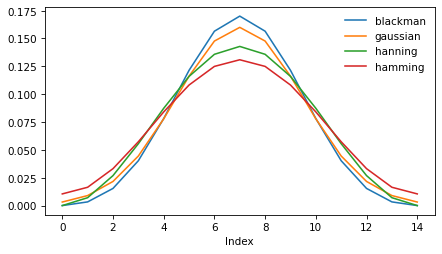

In [36]:
for window, name in zip(windows, names):
    plt.plot(window, label=name)

decorate(xlabel='Index')

They are pretty similar.
Let's see what their DFTs look like:

In [37]:
def plot_window_dfts(windows, names):
    for window, name in zip(windows, names):
        padded = thinkdsp.zero_pad(window, len(wave))
        dft_window = np.fft.rfft(padded)
        plt.plot(abs(dft_window), label=name)

Also pretty similar, but it looks like Hamming drops off the fastest, Blackman the slowest, and Hanning has the most visible sidelobes.

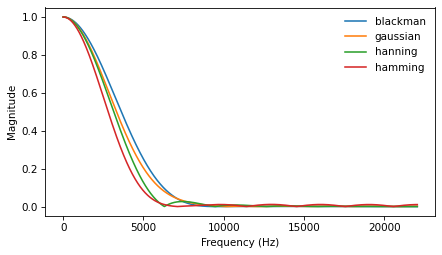

In [38]:
plot_window_dfts(windows, names)
decorate_freq()

Here's the same plot on a log-y scale.

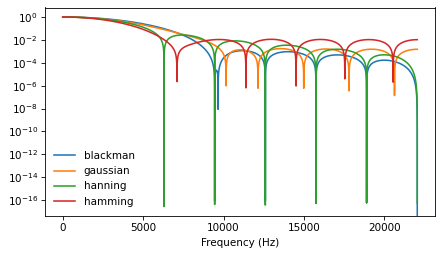

In [39]:
plot_window_dfts(windows, names)
decorate(xlabel='Frequency (Hz)', yscale='log')

On a log scale we can see that the Hamming and Hanning drop off faster than the other two at first.
And the Hamming and Gaussian windows seem to have the most persistent sidelobes.
The Hanning window might have the best combination of fast drop off and minimal sidelobes.

[Think DSP: Digital Signal Processing in Python, 2nd Edition](https://allendowney.github.io/ThinkDSP2/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)